***`Machine learning model deployment`*** is the process of making your machine learning model accessible to someone or something else.

Someone else being a person who can interact with your model in some way.

The model should be able to perform within the following metrics in this case:
1. Performance: 95%+ accuracy.
2. Speed: real-time inference of 30FPS+ (each prediction has a latency of lower than ~0.03s).

There will be a comparison between two best performing to achieve the above results:
> `EfficientNetB2` feature extractor with adjusted classifier layers.

> `ViT-B/16` feature extractor with adjusted head layers.

Walkthrough guide from [here](https://github.com/SaintJeane/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb)

## 0.Setup

In [ ]:
from IPython.display import display
import ipywidgets as widgets

display(widgets.IntSlider())  # or any widget to re-trigger widget state

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1401 (delta 1401), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 40.03 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Getting Data

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2.Creating EffNetB2 feature extractor

In [5]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup the pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights="DEFAULT")

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 128MB/s]


In [6]:
# Check out the classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [7]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3) # len(class_names)
)

### Creating a function to make EffNetB2 feature extractor

In [8]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  """
  Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
  # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in base model
  for param in model.parameters():
      param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes),
  )

  return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [10]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
# Setup DataLoaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### Training EffNetB2 feature extractor

In [12]:
#Setup optimizer and loss function
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds and train the model
set_seeds()
effnetb2_model_results = engine.train(model=effnetb2,
                                      train_dataloader=train_dataloader_effnetb2,
                                      test_dataloader=test_dataloader_effnetb2,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### Inspecting EffNetB2 using loss curves

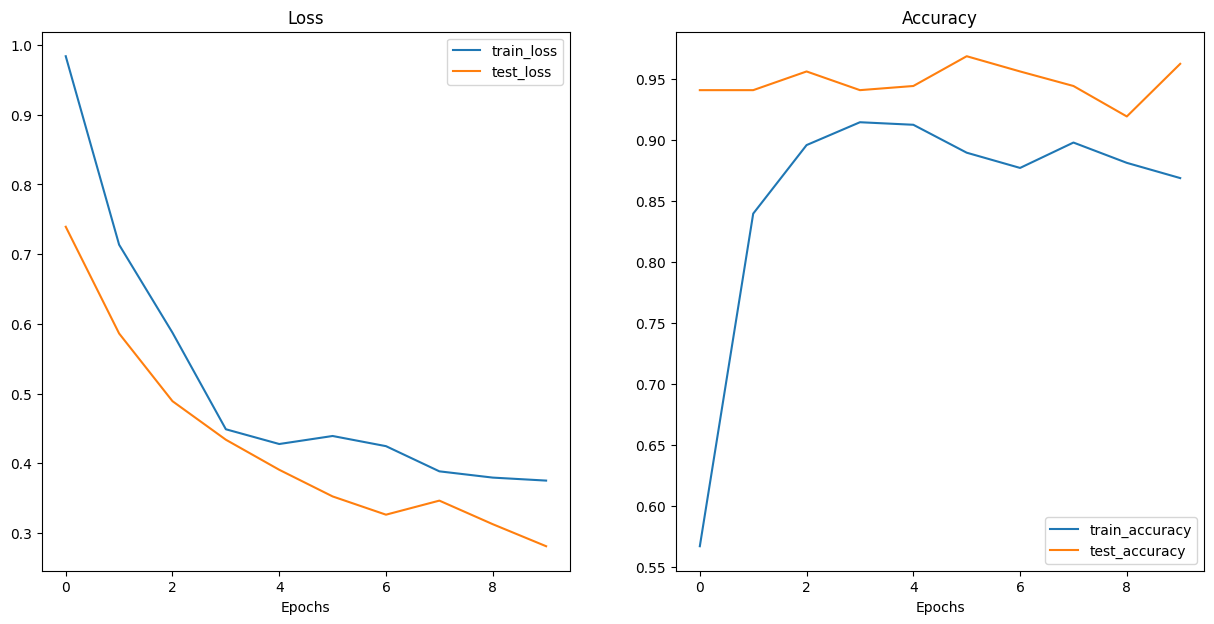

In [13]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_model_results)

### Saving EffNetB2 model

In [14]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [15]:
# Checking the size of EffNetB2 model
from pathlib import Path

# Get the model size in bytes then convert to MB
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### Collecting EffNetB2 feature extractor stats

In [16]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [17]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    "test_loss": effnetb2_model_results['test_loss'][-1],
    "test_acc": effnetb2_model_results['train_acc'][-1],
    "number_of_parameters": effnetb2_total_params,
    "model_size (MB)": pretrained_effnetb2_model_size

}
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.86875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [18]:
effnetb2_model_results['test_acc'][-1]

0.9625

## 3.Creating ViT feature extractor

In [19]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  """Creates a ViT-B/16 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of target classes. Defaults to 3.
      seed (int, optional): random seed value for output layer. Defaults to 42.

  Returns:
      model (torch.nn.Module): ViT-B/16 feature extractor model.
      transforms (torchvision.transforms): ViT-B/16 image transforms.
  """
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all layers in model
  for param in model.parameters():
      param.requires_grad = False

  # Change classifier head to suit our needs (this will be trainable)
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                        out_features=num_classes)) # update to reflect target number of classes

  return model, transforms

In [21]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 81.8MB/s]


In [22]:
from torchinfo import summary
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Creating DataLoaders for ViT

In [23]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### Training the ViT model

In [24]:
from going_modular.going_modular import engine
# Setup the optimizer and the loss function
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds and train the model
set_seeds()

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### ViT loss curves

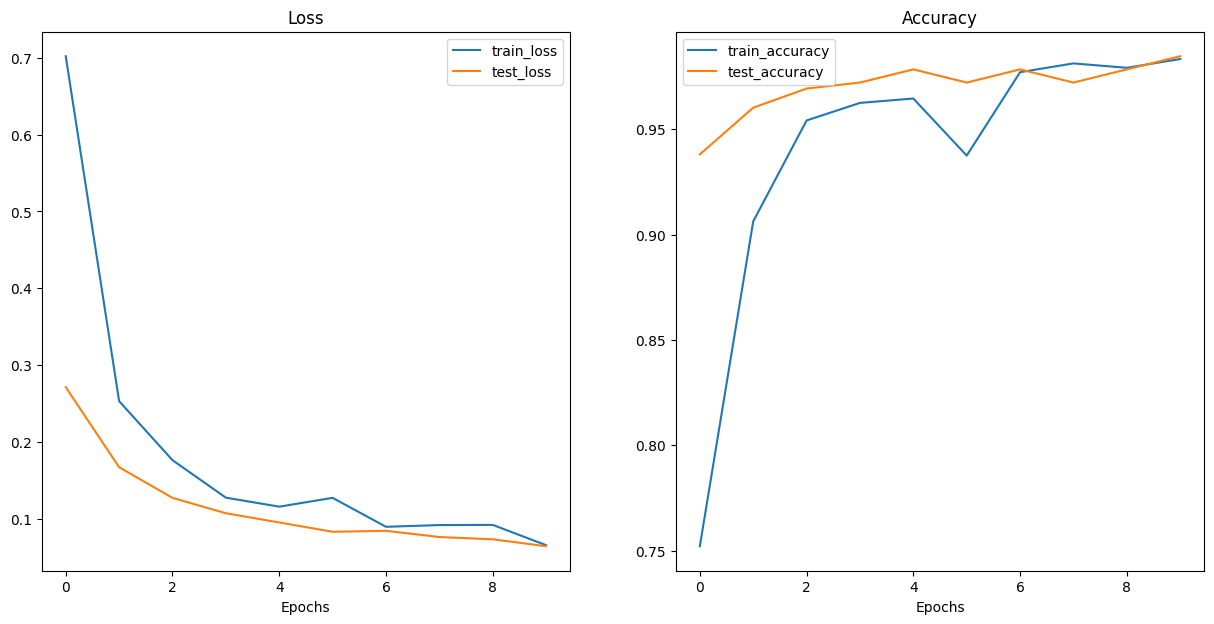

In [25]:
plot_loss_curves(vit_results)

### Saving the ViT model

In [26]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [27]:
# Checking the size of vit model
from pathlib import Path
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### Collecting ViT model stats

In [28]:
# Count the number of parameters
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [29]:
# Create a ViT statistics dict
vit_stats = {"test_loss": vit_results['test_loss'][-1],
             "test_acc": vit_results['test_acc'][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [30]:
vit_results['test_acc'][-1]

0.984659090909091

## 4.Making predictions with the trained models and timing them

In [31]:
from pathlib import Path

# Get all test data paths
print(f"Finding all filepaths ending with '.jpg' in directory {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

Finding all filepaths ending with '.jpg' in directory data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2948087.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/715227.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3227791.jpg')]

In [32]:
test_data_paths[1].parent.stem

'sushi'

In [33]:
# files_test = list(test_dir.glob("*/*.jpg"))
# files_test[-13:]

### Creating a function to make predictions across the test dataset

In [34]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2. Create an empty list to store prediction dictionaries
  pred_list = []

  # 3. Loop through target paths
  for path in tqdm(paths):

    # 4. Create empty dictionary to store prediction information for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth class name
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open image path
    img = Image.open(path)

    # 8. Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare model for inference by sending it to target device and turning on eval() mode
    model.to(device)
    model.eval()

    # 10. Get prediction probability, prediction label and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image) # perform inference on target sample
      pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilitie into prediction label
      pred_class = class_names[pred_label.cpu()] # hardcode prediction class to the CPU

      # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict['pred_class'] = pred_class

      # 12. End the timer and calculate the time per prediction
      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time-start_time, 4)

    # 13. Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # 14. Add the dictionary to the list of preds
    pred_list.append(pred_dict)

  # 15. Return list of prediction dictionaries
  return pred_list

In [35]:
class_names

['pizza', 'steak', 'sushi']

### Making predictions with EffNetB2 model

In [36]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # Making predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1600999.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9556,
  'pred_class': 'sushi',
  'time_for_pred': 0.357,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8276,
  'pred_class': 'sushi',
  'time_for_pred': 0.1513,
  'correct': True}]

In [38]:
# Turn the test_pred_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.tail(10)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
140,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9567,pizza,0.0950,True
141,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9412,pizza,0.0940,True
142,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9312,pizza,0.0914,True
143,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9468,pizza,0.1063,True
144,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.6982,pizza,0.0911,True
145,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.4744,pizza,0.0961,True
146,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.8139,pizza,0.0915,True
147,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7070,pizza,0.1044,True
148,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.7100,pizza,0.0918,True
149,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.6586,pizza,0.0982,True


In [39]:
# Check the number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [40]:
# Finding the average prediction time
effnet_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnet_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.106 seconds


In [41]:
effnetb2_stats["time_per_pred_cpu"] = effnet_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.86875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': np.float64(0.106)}

### Making Predictions with ViT model

In [42]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [43]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1600999.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9945,
  'pred_class': 'sushi',
  'time_for_pred': 0.6808,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9967,
  'pred_class': 'sushi',
  'time_for_pred': 0.4947,
  'correct': True}]

In [44]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9945,sushi,0.6808,True
1,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9967,sushi,0.4947,True
2,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9956,sushi,0.5037,True
3,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.9852,sushi,0.4887,True
4,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.4975,pizza,0.5090,False


In [45]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [46]:
# Calculate ave. time for prediction with vit model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6034 seconds


In [47]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': np.float64(0.6034)}

## 5.Comparing model results, prediction times and size

In [48]:
# Turn stat dictionaries into dataframe
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"]*100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,86.88,7705221,29,0.1060,EffNetB2
1,0.064435,98.47,85800963,327,0.6034,ViT


In [49]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc['ViT']/df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratio"])

,ViT to EffNetB2 ratio
test_loss,0.229233
test_acc,1.133402
number_of_parameters,11.135432
model_size (MB),11.275862
time_per_pred_cpu,5.692453


### Visualizing speed vs performance tradeoff

mkdir: cannot create directory ‘images/’: File exists


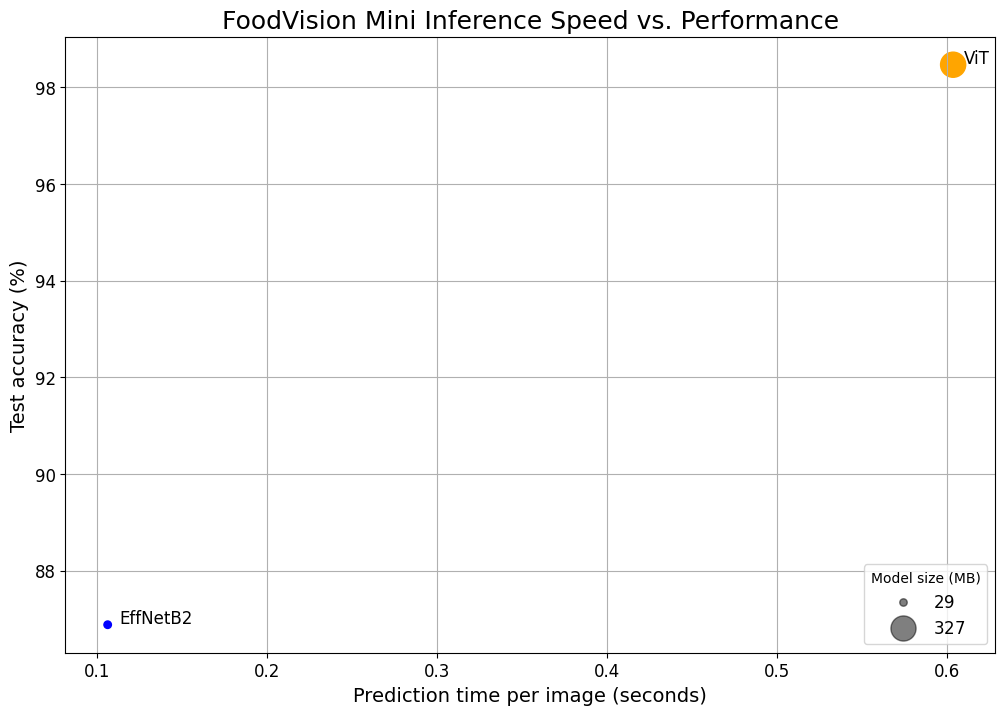

In [52]:
# 1. Create a plot from model comaprison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use
                     s='model_size (MB)') # size of the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs. Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)",  fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
  ax.annotate(text=row["model"], # model
              xy=(row['time_per_pred_cpu']+0.0066, row["test_acc"]+0.03), # [X, y]
              size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# 5. Save the figure
!mkdir images/
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 6.Bringing FoodVision Mini to life by creating a Gradio demo

In [53]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00
Gradio version: 5.31.0


In [54]:
# Put EffNetB2 on the CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

### Creating a function to map the inputs and outputs

In [55]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  """
  Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer()-start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

In [56]:
range(len(class_names))

range(0, 3)

In [57]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the image
image = Image.open(random_image_path)
print(f"Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}\n")
print(f"Prediction time: {pred_time} seconds")

Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/697562.jpg

Prediction label and probability dictionary: 
{'pizza': 0.15116561949253082, 'steak': 0.7444073557853699, 'sushi': 0.10442705452442169}

Prediction time: 0.09631 seconds


In [58]:
# Create a list of example inputs to the Gradio demo
example_list = [[str(filepath) for filepath in random.sample(test_data_paths, k=3)]]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg',
  'data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg',
  'data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg']]

### Building a Gradio Interface
> input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken

We can do with the gradio.Interface() class with the following parameters:

- fn - a Python function to map inputs to outputs, in our case, we'll use our predict() function.
- inputs - the input to our interface, such as an image using gradio.Image() or "image".
- outputs - the output of our interface once the inputs have gone through the fn, such as a label using gradio.Label() (for our model's predicted labels) or number using gradio.Number() (for our model's prediction time).
>**Note:** Gradio comes with many in-built inputs and outputs options known as "Components".
- examples - a list of examples to showcase for the demo.
- title - a string title of the demo.
- description - a string description of the demo.
- article - a reference note at the bottom of the demo.
Once we've created our demo instance of `gr.Interface()`, we can bring it to life using `gradio.Interface().launch()` or `demo.launch()` command.

In [59]:
import gradio as gr

# Create a title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = """
        ## 🍽️ FoodVision Mini: Classifying Pizza, Steak, and Sushi with Deep Learning

        FoodVision Mini is a compact computer vision demo built using a pre-trained **EfficientNetB2** model. It classifies food images into one of three categories: **pizza**, **steak**, or **sushi**.

        ### 🔍 How It Works
        - The model uses EfficientNetB2 as a **feature extractor**.
        - It predicts the top 3 most likely classes for any input image.
        - Built with **Gradio**, the interface allows easy interaction for testing the model.

        ### ⚙️ Model Details
        - **Model Architecture**: EfficientNetB2 (from `torchviosion.models`)
        - **Prediction Output**: Top 3 class probabilities
        - **Use Case**: Great for food classification demos.

        ### 🚀 Try It Out
        Upload an image of food (pizza, steak, or sushi) or use one of the provided examples to see predictions and inference time.
      """
# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time(s)")], # this fn has two outputs, therefore there are two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://215335a8d160359b40.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7.Turning the FoodVision Mini Gradio Demo into a deployable app

Package the demo into an app and upload it to Hugging Face Spaces.

Adopting the following file structure:

    demos/
    └── foodvision_mini/
        ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
        ├── app.py
        ├── examples/
        │   ├── example_1.jpg
        │   ├── example_2.jpg
        │   └── example_3.jpg
        ├── model.py
        └── requirements.txt

### Creating a `demos` folder to store the FoodVision Mini app files

In [60]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/food_vision_mini")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)  # Deleting the directory and its contents
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what is in the folder
!ls demos/food_vision_mini/

In [61]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path/"examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Collect the three random images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path/example.name
  print(f"Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/food_vision_mini/examples/592799.jpg
Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/food_vision_mini/examples/3622237.jpg
Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/food_vision_mini/examples/2582289.jpg


In [62]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

### Moving the trained EffNetB2 model to FoodVision Mini demo directory

In [63]:
import shutil

# Create a source path for target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  print("[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
  print(f"No model found at {effnetb2_foodvision_mini_model_path}, perhaps it has already been moved?")
  print(f"Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/food_vision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### Turning our EffNetB2 model into a Python script (`model.py`)

In [98]:
%%writefile demos/food_vision_mini/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  """
  Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
  """
  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights="DEFAULT")

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408,
                out_features=num_classes)
  )

  return model, transforms

Overwriting demos/food_vision_mini/model.py


### Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

In [97]:
%%writefile demos/food_vision_mini/app.py
# !pip install gradio
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model()

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth", map_location=torch.device("cpu")) # Load on CPU
)

### 3. Predict function ###
# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """
  Transforms and perform a prediction on img and returns prediction and time taken.
  """
  # Start timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put the model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))} # --> pred_probs[0][i] is the probability for class i of the first input

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = """
        ## 🍽️ FoodVision Mini: Classifying Pizza, Steak, and Sushi with Deep Learning

        FoodVision Mini is a compact computer vision demo built using a pre-trained **EfficientNetB2** model. It classifies food images into one of three categories: **pizza**, **steak**, or **sushi**.

        ### 🔍 How It Works
        - The model uses EfficientNetB2 as a **feature extractor**.
        - It predicts the top 3 most likely classes for any input image.
        - Built with **Gradio**, the interface allows easy interaction for testing the model.

        ### ⚙️ Model Details
        - **Model Architecture**: EfficientNetB2 (from `torchviosion.models`)
        - **Prediction Output**: Top 3 class probabilities
        - **Use Case**: Great for food classification demos.

        ### 🚀 Try It Out
        Upload an image of food (pizza, steak, or sushi) or use one of the provided examples to see predictions and inference time.
      """
# Create examples list from 'examples/' directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time(s)")], # this fn has two outputs, therefore there are two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch()

Overwriting demos/food_vision_mini/app.py


### Creating a requirements file for FoodVision Mini (`requirements.txt`)

In [96]:
%%writefile demos/food_vision_mini/requirements.txt
torch
torchvision
gradio

Overwriting demos/food_vision_mini/requirements.txt


## 8.Deploying our FoodVision Mini app to HuggingFace Spaces

In [70]:
!ls demos/food_vision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


First compressing into a single zip by this command:
> zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

Where:
- `zip` stands for "zip" as in "please zip together the files in the following directory".
- `-r` stands for "recursive" as in, "go through all of the files in the target directory".
- `../foodvision_mini.zip` is the target directory we'd like our files to be zipped to.
- `*` stands for "all the files in the current directory".
- `-x` stands for "exclude these files".

In [73]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/food_vision_mini && zip -r ../food_vision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__" "*ipynb_checkpoints*"

# Download the zipped Foodvision Mini app (if running in Google Colab)
try:
  from google.colab import files
  files.download("demos/food_vision_mini.zip")
except:
  print("Not running in Google COlab, can't use google.colab.files.download(), please manually download.")

updating: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: app.py (deflated 57%)
updating: examples/ (stored 0%)
updating: examples/2582289.jpg (deflated 17%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/592799.jpg (deflated 1%)
updating: model.py (deflated 55%)
updating: requirements.txt (deflated 46%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Running our FoodVision Mini demo locally (for windows)**
If you download the foodvision_mini.zip file, you can test it locally by:
1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Creating an environment (`python -m venv env`).
5. Activating the environment (`source env/Scripts/activate`).
6. Installing the requirements (`pip install -r requirements.txt`, the "-r" is for recursive).
> Note: This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade pip first: `pip install --upgrade pip`.
7. Run the app (`python app.py`).

This should result in a Gradio demo just like the one we built above running locally on your machine at a URL such as `http://127.0.0.1:7860/`.

### Uploading to HuggingFace

In [5]:
# Ipython is a library to help make Python interactive
from IPython.display import HTML

# Embed FoodVision Mini Gradio demo
HTML('''
    <iframe
	src="https://saint5-food-vision-mini.hf.space"
	frameborder="0"
	width="950"
	height="750"
></iframe>
'''
)

# **9.Creating FoodVision Big**

In [74]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [75]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [76]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

Compare `food101_train_transforms` (for the training data) and `effnetb2_transforms` (for the testing/inference data).

In [77]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### Getting Data for FoodVision Big

In [78]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # Download the data

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

100%|██████████| 5.00G/5.00G [03:35<00:00, 23.2MB/s]


In [79]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first ___
food101_class_names[:15]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake']

### Creating a subset of Food101 for faster experimenting
This is splitting the dataset and using the 20% of the data.

In [80]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
  """
  Randomly splits a given dataset into two proportions based on split_size and seed.

  Args:
      dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
      split_size (float, optional): How much of the dataset should be split?
          E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
      seed (int, optional): Seed for random generator. Defaults to 42.

  Returns:
      tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
          random_split_2 is of size (1-split_size)*len(dataset).
    """
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size) # desired length
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"SPLITTING DATASET OF LENGHT {len(dataset)} INTO SPLITS OF SIZE: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset=dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed)) # Setting the random seed for reproducibility
  return random_split_1, random_split_2

In [81]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

SPLITTING DATASET OF LENGHT 75750 INTO SPLITS OF SIZE: 15150 (20%), 60600 (80%)
SPLITTING DATASET OF LENGHT 25250 INTO SPLITS OF SIZE: 5050 (20%), 20200 (80%)


(15150, 5050)

### Turning the Food101 datasets into `DataLoaders`

In [82]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False,
                                                                  num_workers=NUM_WORKERS)

### Training FoodVision Big model

In [86]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # label smoothing because of so many classes

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2663 | train_acc: 0.5907 | test_loss: 2.2713 | test_acc: 0.5746
Epoch: 2 | train_loss: 2.2517 | train_acc: 0.5976 | test_loss: 2.2692 | test_acc: 0.5826
Epoch: 3 | train_loss: 2.2292 | train_acc: 0.6028 | test_loss: 2.2630 | test_acc: 0.5796
Epoch: 4 | train_loss: 2.2006 | train_acc: 0.6119 | test_loss: 2.2520 | test_acc: 0.5812
Epoch: 5 | train_loss: 2.2104 | train_acc: 0.6087 | test_loss: 2.2634 | test_acc: 0.5847


###  Inspecting loss curves of FoodVision Big model

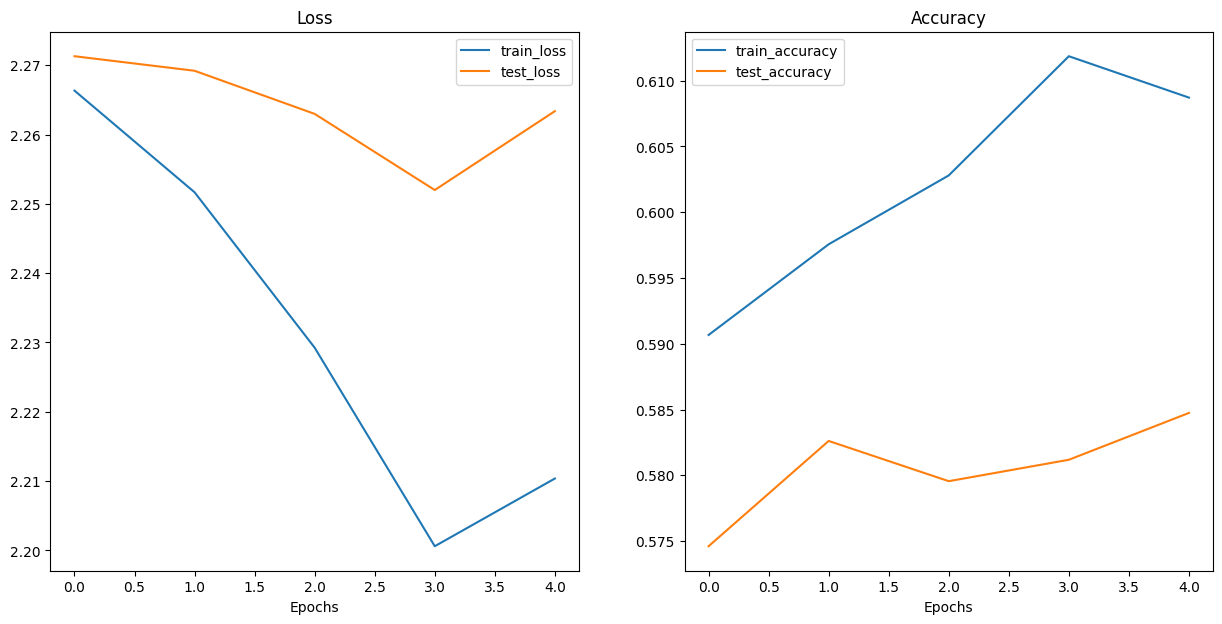

In [87]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### Saving and loading FoodVision Big

In [88]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save the model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [89]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state dict
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth" ))

<All keys matched successfully>

In [90]:
# Check FoodVision Big model size
from pathlib import Path

pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # rough conversion to MBs
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 10.Turning FoodVision Big model into deploayble app

Adopting the following food structure:

    demos/
      foodvision_big/
        09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
        app.py
        class_names.txt
        examples/
          example_1.jpg
        model.py
        requirements.txt

In [91]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path/"examples").mkdir(parents=True, exist_ok=True)

In [92]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-05-26 00:47:43--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.05s   

2025-05-26 00:47:43 (50.7 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### Saving Food101 class names to file (`class_names.txt`)

In [93]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [94]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"Saving Food101 class names to {foodvision_big_class_names_path}")
  f.write("\n".join(food101_class_names)) # leave a new line between each class

Saving Food101 class names to demos/foodvision_big/class_names.txt


In [95]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### Turning FoodVision Big model into a Python script (`model.py`)

In [99]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=101,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


Turning our FoodVision Big Gradio app into a Python script (`app.py`)

In [111]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2.load_state_dict(torch.load(f="09_pretrained_effnetb2_feature_extractor_20_percent.pth",
                                    map_location=torch.device("cpu")))

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """
  Transforms and performs a prediction image and returns prediction and time taken.
  """
  # Start timer
  start_time = timer()

  # Transform the target image and add a batch
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put the model into evaluation mode and turn on torch inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

title = "FoodVision Big 🍲🍽️"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into 101 different classes."
article = """
  FoodVision Big is a state-of-the-art image classification model based on EfficientNetB2, trained to recognize 101 different food categories.
  Upload an image of food to see the top predicted classes along with their confidence scores.
  """
# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs = gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time(s)")
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article
)

# Launch the app
demo.Launch()

Overwriting demos/foodvision_big/app.py


### Creating requirements file for FoodVision Big (`requirements.txt`)

In [102]:
%%writefile demos/foodvision_big/requirements.txt
torch
torchvision
gradio

Writing demos/foodvision_big/requirements.txt


### Downloading FoodVision Big app files

In [107]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Dwnload the zipped Foodvision Big app
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print("Not running in Google Colab, can't use google.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Embedding the FoodVision Big Gradio demo right within the notebook as an iframe and a link to the space in the format `https://hf.space/embed/[YOUR_USERNAME]/[YOUR_SPACE_NAME]/+`.

In [3]:
# IPython is a library to help work with Python interactively
from IPython.display import IFrame

# Embed FoodVision Big Gradio demo as an IFrame
IFrame(src="https://saint5-foodvision-big.hf.space", width=900, height=750)

In [4]:
# Alternative display using HTML
from IPython.display import HTML
HTML('''
<iframe
	src="https://saint5-foodvision-big.hf.space"
	frameborder="0"
	width="900"
	height="750"
></iframe>
''')

***Learn about machine learning model deployment (MLOPS)***